In [1]:
import pandas as pd
import pathlib
import requests
import time
import dataclasses
from typing import Iterator
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from PIL import Image
import io
import concurrent.futures

In [2]:
@dataclasses.dataclass
class Row:
    image: NDArray[np.uint8]
    name: str

In [3]:
def download(url: str) -> bytes:
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.content
    except requests.RequestException as e:
        print(f"  -> Error downloading {url}: {e}")
        return b''

Esta funcion pasa de bytes a imagen para imprimir.

In [4]:
def bytes_to_image(image_bytes: bytes) -> NDArray[np.uint8]:
    """
    Convierte un objeto de bytes a un array de NumPy (imagen RGB).

    Si los bytes están vacíos o no se pueden procesar como una imagen, devuelve None.
    """

    # Intenta abrir los bytes, convertirlos a RGB y devolverlos como un array
    image_stream = io.BytesIO(image_bytes)
    image = Image.open(image_stream).convert("RGB")
    return np.array(image)

Generador CON HILOS

La descarga de imágenes es una tarea limitada por Entrada/Salida (E/S), no por la capacidad del procesador (CPU). Esto significa que el programa pasa la mayor parte del tiempo esperando a que la red responda y envíe los datos, en lugar de estar haciendo cálculos intensivos. Se eligen los hilos porque la descarga de archivos es fundamentalmente un problema de espera. Los hilos son la forma más eficiente de gestionar y aprovechar múltiples "esperas" al mismo tiempo.

In [23]:
def create_concurrent_row_iterator(folder_path: str, max_workers: int = 10) -> Iterator[Row]:
    """
    Usa un ThreadPoolExecutor para descargar múltiples imágenes simultáneamente
    y genera los objetos 'Row' a medida que se completan las descargas.
    """
    path = pathlib.Path(folder_path)
    csv_files = list(path.glob('*.csv'))
    if not csv_files:
        return

    # PASO 1: Recopila todas las tareas (nombre y url) primero
    tasks = []
    for file in csv_files:
        try:
            df = pd.read_csv(file, usecols=['Pokemon', 'Sprite'])
            for _, data_row in df.iterrows():
                tasks.append((data_row['Pokemon'], data_row['Sprite']))
        except ValueError:
            continue

    # PASO 2: Crea el equipo de hilos y asigna las tareas
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 'future' es una promesa de que la descarga se completará en el futuro.
        # Creamos un diccionario para recordar a qué Pokémon pertenece cada 'future'.
        future_to_pokemon = {
            executor.submit(download, url): name for name, url in tasks
        }

        # PASO 3: Procesa los resultados a medida que llegan
        for future in concurrent.futures.as_completed(future_to_pokemon):
            name = future_to_pokemon[future]
            try:
                image_bytes = future.result() # Obtiene el resultado (los bytes) de la descarga
                image_array = bytes_to_image(image_bytes)
                yield Row(image=image_array, name=name)
            except Exception as exc:
                print(f'{name} generó una excepción: {exc}')

Produce, la funcion del profesor. que imprime la imagen

In [24]:
def produce(iterator: Iterator[Row]):
    print("\nRequesting next item from iterator...")
    t0 = time.perf_counter()
    try:
        row = next(iterator)
        print(f"Operation took {time.perf_counter() - t0:.2f} seconds.")
        plt.figure()
        plt.imshow(row.image)
        plt.title(row.name)
        plt.axis('off')
        plt.show()
        return row
    except StopIteration:
        print("\nAll items have been processed.")
        return None


Requesting next item from iterator...
Operation took 0.34 seconds.


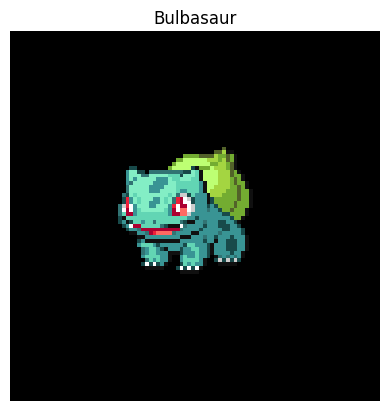

In [25]:
if __name__ == "__main__":
    ruta_carpeta = "C:/Users/paula/Downloads/computer-vision-data-loader-main/computer-vision-data-loader-main/data"
    # Crea el iterador CONCURRENTE
    row_iterator = create_concurrent_row_iterator(ruta_carpeta, max_workers=10)
    produce(row_iterator)